Available columns in the dataset:
 ['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions', 'Light_conditions', 'Weather_conditions', 'Type_of_collision', 'Number_of_vehicles_involved', 'Number_of_casualties', 'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity', 'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity']
Fitting 5 folds for each of 9 candidates, totalling 45 fits

All parameter combinations with F1 and Accuracy:

Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2} --> Mean F1: 0.8043 | Mean Accuracy: 0.8066
Params: {'class_weight': 'balanced', 'max_depth':

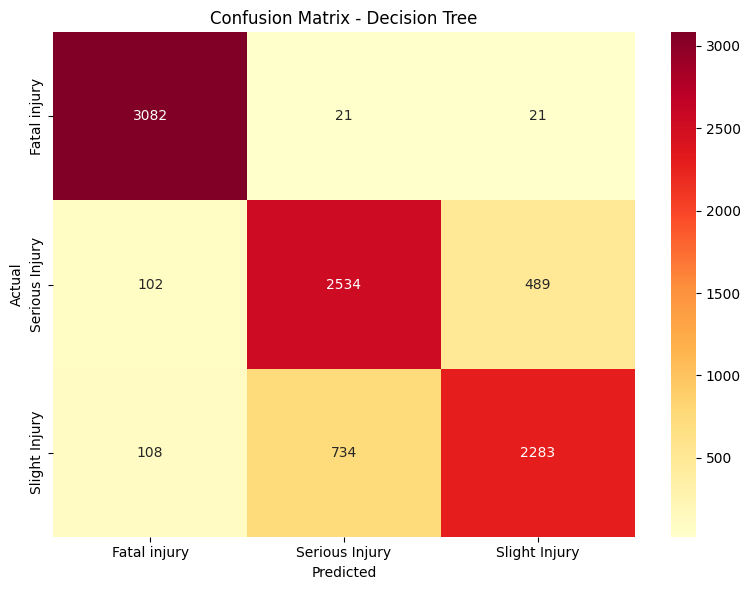

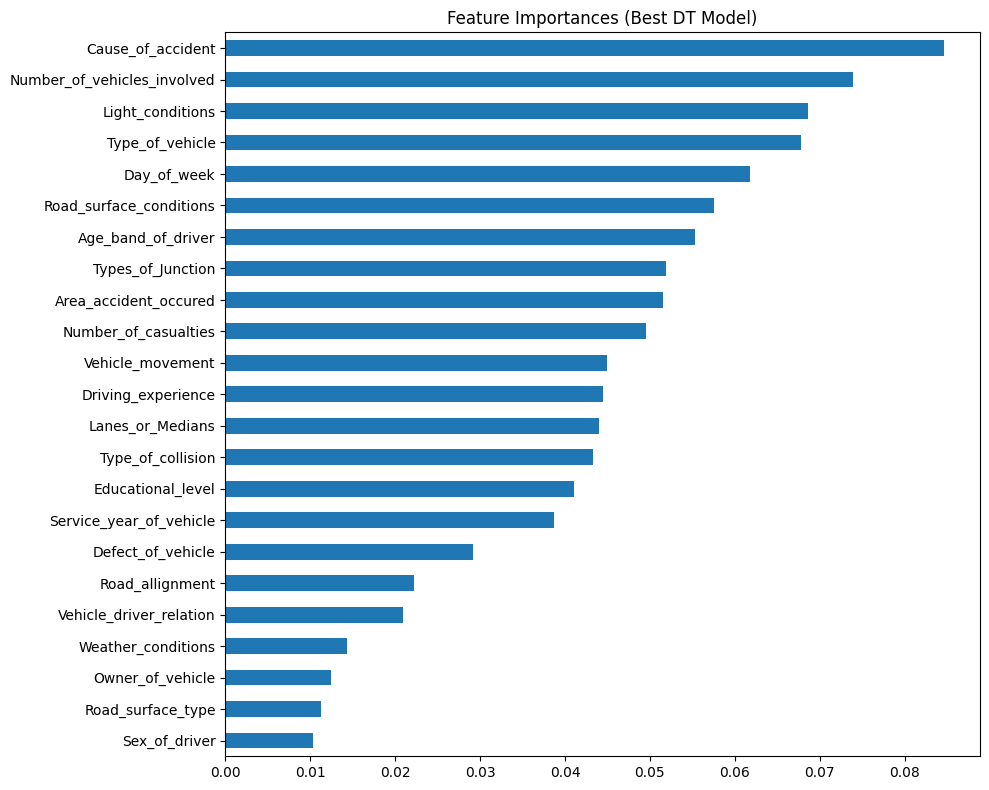

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("RTA Dataset.csv")
print("Available columns in the dataset:\n", df.columns.tolist())

# Selected features
selected_features = [
    'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver', 'Educational_level',
    'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
    'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
    'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
    'Types_of_Junction', 'Road_surface_type', 'Road_surface_conditions',
    'Light_conditions', 'Weather_conditions', 'Type_of_collision',
    'Number_of_vehicles_involved', 'Number_of_casualties',
    'Vehicle_movement', 'Cause_of_accident'
]
target = 'Accident_severity'

# Subset the dataframe
df = df[selected_features + [target]]

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].mean())

# Label encoding
label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Feature-target split
X = df.drop(target, axis=1)
y = df[target]

# Apply SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Grid Search for Decision Tree
param_grid = {
    'max_depth': [ 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt, param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1_macro',
    return_train_score=True,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Show F1 and Accuracy per configuration
print("\nAll parameter combinations with F1 and Accuracy:\n")
for i, params in enumerate(grid_search.cv_results_['params']):
    f1 = grid_search.cv_results_['mean_test_score'][i]
    model = DecisionTreeClassifier(**params, random_state=42)
    acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=StratifiedKFold(n_splits=5)).mean()
    print(f"Params: {params} --> Mean F1: {f1:.4f} | Mean Accuracy: {acc:.4f}")

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("\nBest Model Evaluation:")
print(report_df)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=label_encoders[target].classes_,
            yticklabels=label_encoders[target].classes_)
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Feature importance
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=True)
plt.figure(figsize=(10, 8))
feat_imp.plot(kind='barh', title='Feature Importances (Best DT Model)')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.tree import plot_tree


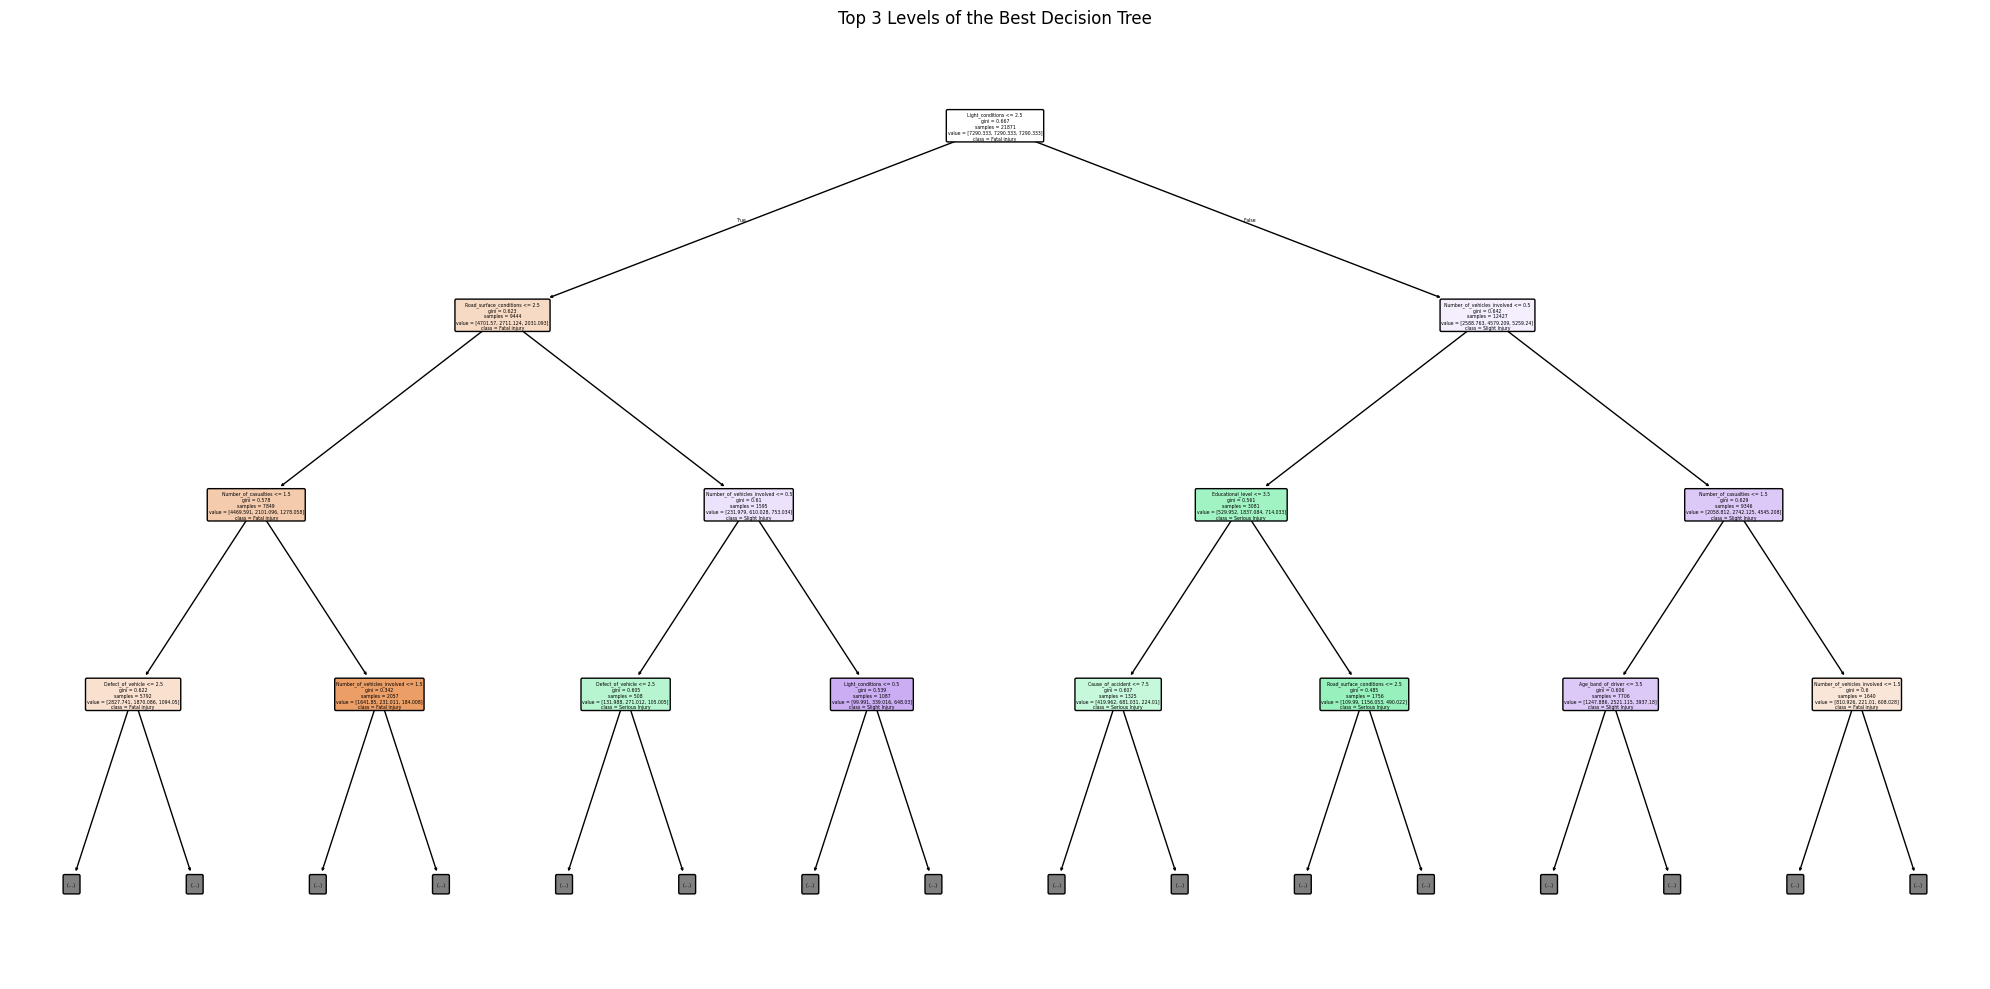

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=label_encoders[target].classes_,
    filled=True,
    rounded=True,
    max_depth=3  # Display only first 3 levels for readability
)
plt.title("Top 3 Levels of the Best Decision Tree")
plt.tight_layout()
plt.show()
